In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from scipy.special import expit
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import wandb
from sklearn.model_selection import KFold


In [5]:
class MyDecisionTreeClassifier:
    def __init__(self, **kwargs):
        self.model = DecisionTreeClassifier(**kwargs)

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def validate(self,X_val, y_val):
        predictions = self.model.predict(X_val)
        accuracy = accuracy_score(y_val, predictions)
        return accuracy

    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions
    
    def getClassificationReport(self, y_true, y_pred):
        self.report = classification_report(y_pred,y_true,zero_division=1)
        return self.report


In [6]:
class GBT_Classifier:
    def __init__(self, n_estimators=100, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def compute_gradient(self, y, y_pred):
        # Compute the negative gradient of the log-likelihood loss function
        return y - self.sigmoid(y_pred)
    
    def fit(self, X, y):
        # Initialize the prediction with the log-odds of the class probabilities
        initial_prediction = np.log(np.bincount(y) / len(y))
        prediction = np.full_like(y, initial_prediction[1], dtype=float)  # Use initial_prediction[1] for the positive class

        for _ in range(self.n_estimators):
            # Compute the negative gradient of the log-likelihood loss function
            gradient = self.compute_gradient(y, prediction)

            # Fit a decision tree regressor to the negative gradient
            tree = DecisionTreeRegressor(max_depth=3)
            tree.fit(X, gradient)

            # Update the prediction using the learning rate and predictions from the tree
            prediction += self.learning_rate * tree.predict(X)

            # Store the tree in the list of models
            self.models.append(tree)

    def predict(self, X):
        # Make predictions by summing the predictions from each tree and applying the sigmoid function
        predictions = np.sum([self.learning_rate * model.predict(X) for model in self.models], axis=0)
        return np.round(self.sigmoid(predictions))


In [7]:
# loading the data
file_path = './WineQT.csv'

data = pd.read_csv(file_path)
df = pd.DataFrame(data)
df = df.drop(df.columns[-1], axis=1)
labels = df.columns.tolist()

num_features = df.shape[1]-1
num_classes = df.iloc[:, -1].nunique()

X = df.iloc[:, :-1].values
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std


f=0.8

y = df.iloc[:, -1].values
y = y - 3

y = y/5
y = np.where(y<0.5,0,1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
gbt_classifier = GBT_Classifier(n_estimators=100, learning_rate=0.1)
gbt_classifier.fit(X_train, y_train)

# Make predictions on new data
predictions = gbt_classifier.predict(X_test)
print('predicted : ',predictions)
print('ground truth : ',y_test)

predicted :  [1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
ground truth :  [1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0
 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1
 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1
 1 1 0 1]


In [9]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.782608695652174


In [10]:
acc_list = []
inf_time = []
num_est = []

for n in range(100):
    gbt_classifier = GBT_Classifier(n_estimators=n+5, learning_rate=0.1)
    t1 = time.time()
    gbt_classifier.fit(X_train, y_train)
    t2 = time.time()
    predictions = gbt_classifier.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    num_est.append(n+5)
    acc_list.append(acc)
    inf_time.append(t2-t1)
    


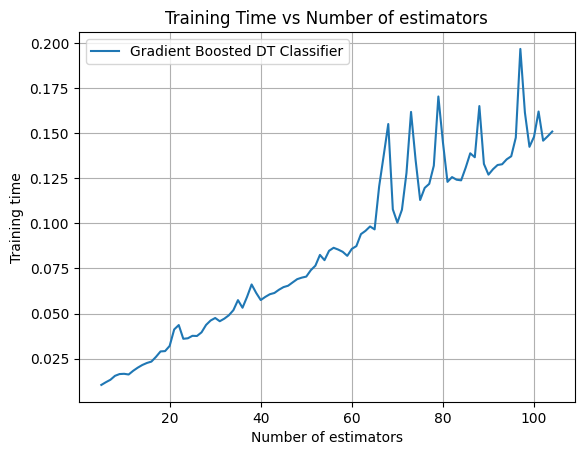

In [11]:
plt.plot(num_est, inf_time, label='Gradient Boosted DT Classifier')
plt.xlabel('Number of estimators')
plt.ylabel('Training time')
plt.legend()
plt.grid()
plt.title('Training Time vs Number of estimators')
plt.show()

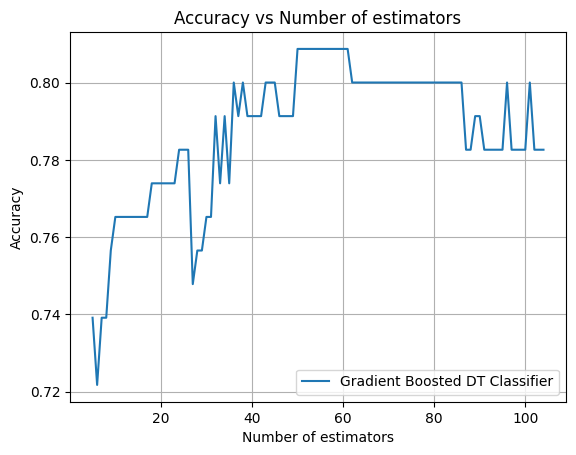

In [12]:
plt.plot(num_est, acc_list, label='Gradient Boosted DT Classifier')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy vs Number of estimators')
plt.show()